In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import os

In [2]:
sys.path.append(os.path.abspath("../src"))

In [3]:
from torchvision.transforms import v2 as T
from pathlib import Path
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torchvision import tv_tensors
import mlflow

In [4]:
from text_detector_model.dataset import DocumentDataset
from text_detector_model.train import train_model
from text_detector_model.model import get_faster_rcnn_model
from utils import plot

In [5]:
data_version = "20250410185834"
batch_size = 16
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# Define transformations for input images
transform = T.Compose([
    T.ToDtype(torch.float, scale=True),
    T.Resize((800, 600)),
    T.ToPureTensor()
])

# Load data
documents_dir = Path(f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_19/{data_version}/")

In [6]:
train_dataset = DocumentDataset(images_dir=documents_dir / "train", annotation_file=documents_dir / "train_labels.json", transform=transform)
test_val_dataset = DocumentDataset(images_dir=documents_dir / "test", annotation_file=documents_dir / "test_labels.json", transform=transform)

# Split into val/test
val_size = int(0.5 * len(test_val_dataset))
test_size = len(test_val_dataset) - val_size

val_dataset, test_dataset = torch.utils.data.random_split(
    test_val_dataset, [val_size, test_size]
)

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [7]:
train_dataset[1][0].shape

torch.Size([3, 800, 600])

In [8]:
train_dataset[1][1]

{'image_id': 1,
 'boxes': tensor([[ 82, 351, 277, 370],
         [358, 215, 515, 235],
         [309, 345, 325, 364],
         [503, 350, 533, 370],
         [132, 207, 254, 238],
         [142, 240, 293, 261],
         [383, 241, 548, 262],
         [368, 351, 384, 372],
         [369, 268, 535, 291],
         [126, 265, 291, 279]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

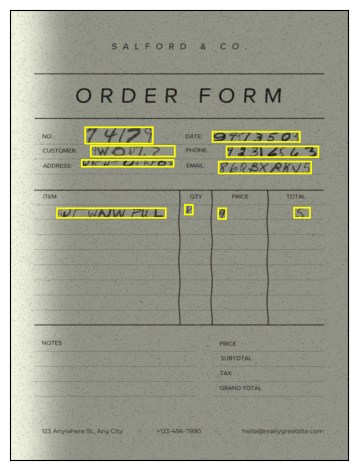

In [9]:
plot([(train_dataset[1][0], train_dataset[1][1])])

In [10]:
# Initialize model
model = get_faster_rcnn_model(len(train_dataset.classes) + 1)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(
#    optimizer,
#    step_size=3,
#    gamma=0.1
#)

In [12]:
mlflow.set_tracking_uri("http://localhost:5000")

In [13]:
num_epochs = 10

with mlflow.start_run():
    params = {
        "num_epochs": num_epochs,
        "optimizer": optimizer.__class__.__name__,
        "batch_size": batch_size,
        "data_version": data_version
    }
    mlflow.log_params(params)

    model = train_model(model=model, 
                        train_data_loader=train_loader, 
                        val_data_loader=val_loader, 
                        optimizer=optimizer, 
                        device="cpu", 
                        num_epochs=num_epochs)

Epoch 1/10


100%|██████████| 50/50 [19:46<00:00, 23.74s/it]


Train Loss: 1.2271
Train Loss Dict: {'loss_classifier': tensor(0.5977, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.4175, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1166, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0953, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:18<00:00, 11.29s/it]


Precision: 0, Recall: 0.0


2025/04/18 20:51:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/10


100%|██████████| 50/50 [18:22<00:00, 22.05s/it]


Train Loss: 0.9860
Train Loss Dict: {'loss_classifier': tensor(0.4323, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.4655, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0297, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0584, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:15<00:00, 10.80s/it]


Precision: 0.0, Recall: 0.0


2025/04/18 21:11:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/10


100%|██████████| 50/50 [18:50<00:00, 22.61s/it]


Train Loss: 0.7731
Train Loss Dict: {'loss_classifier': tensor(0.3033, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3933, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0258, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0508, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:14<00:00, 10.69s/it]


Precision: 0.006611570247933884, Recall: 0.010025062656641603


2025/04/18 21:31:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/10


100%|██████████| 50/50 [20:37<00:00, 24.75s/it]


Train Loss: 0.7008
Train Loss Dict: {'loss_classifier': tensor(0.2564, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3784, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0210, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0450, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:25<00:00, 12.21s/it]


Precision: 0.012468827930174564, Recall: 0.04807692307692308


2025/04/18 21:53:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/10


100%|██████████| 50/50 [18:49<00:00, 22.59s/it]


Train Loss: 0.6570
Train Loss Dict: {'loss_classifier': tensor(0.2213, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3753, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0191, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0413, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Precision: 0.0055617352614015575, Recall: 0.04716981132075472


2025/04/18 22:13:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 6/10


100%|██████████| 50/50 [18:01<00:00, 21.63s/it]


Train Loss: 0.6380
Train Loss Dict: {'loss_classifier': tensor(0.2016, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3796, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0186, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0382, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Precision: 0.006437768240343348, Recall: 0.08108108108108109


2025/04/18 22:33:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/10


100%|██████████| 50/50 [17:31<00:00, 21.04s/it]


Train Loss: 0.6513
Train Loss Dict: {'loss_classifier': tensor(0.1982, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3997, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0169, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0365, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.52s/it]


Precision: 0.003161222339304531, Recall: 0.05555555555555555


2025/04/18 22:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 8/10


100%|██████████| 50/50 [17:30<00:00, 21.01s/it]


Train Loss: 0.6376
Train Loss Dict: {'loss_classifier': tensor(0.1902, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3961, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0156, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0357, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.49s/it]


Precision: 0.01993704092339979, Recall: 0.2878787878787879


2025/04/18 23:10:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 9/10


100%|██████████| 50/50 [17:18<00:00, 20.77s/it]


Train Loss: 0.6261
Train Loss Dict: {'loss_classifier': tensor(0.1855, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.3924, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0154, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0327, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.46s/it]


Precision: 0.013584117032392894, Recall: 0.23214285714285715


2025/04/18 23:29:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 10/10


100%|██████████| 50/50 [17:15<00:00, 20.72s/it]


Train Loss: 0.6669
Train Loss Dict: {'loss_classifier': tensor(0.1903, grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.4279, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0150, grad_fn=<DivBackward0>), 'loss_rpn_box_reg': tensor(0.0336, grad_fn=<DivBackward0>)}
Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.45s/it]


Precision: 0.015527950310559006, Recall: 0.30612244897959184


2025/04/18 23:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-crab-620 at: http://localhost:5000/#/experiments/0/runs/5b6e2cb8e03542eab2f9fe20c69d77e0
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [16]:
from text_detector_model.evaluation import evaluate_model

In [19]:
[false_negatives_df, positives_df], [precision, recall] = evaluate_model(model, val_loader, device, prediction_threshold=0.5, iou_thresold=0.90)

Evaluating model


100%|██████████| 7/7 [01:14<00:00, 10.64s/it]


In [21]:
precision, recall

(0.13768115942028986, 0.7964071856287425)

In [22]:
image = val_dataset[0][0]
val_dataset[0][1]

{'image_id': 120,
 'boxes': tensor([[ 51, 347, 293, 368],
         [346, 209, 542, 237],
         [306, 344, 326, 364],
         [485, 349, 542, 366],
         [154, 207, 258, 238],
         [142, 242, 264, 259],
         [359, 244, 540, 263],
         [392, 356, 414, 370],
         [345, 268, 554, 290],
         [158, 273, 287, 287]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [23]:
false_negatives_df[false_negatives_df["image_id"] == 120]

,target_box,class,image_id,score,predicted_box


In [24]:
positives_df[positives_df["image_id"] == 120]

,target_box,class,image_id,score,predicted_box,predicted_poly,target_poly,intersection_area,union_area,IoU
0,"[51, 347, 293, 368]",1,120,0.968165,"[51.450977, 347.2236, 288.07184, 368.60013]","POLYGON ((51.45097732543945 347.2236022949219,...","POLYGON ((51 347, 51 368, 293 368, 293 347, 51...",4916.129115,5224.002845,0.941066
1,"[346, 209, 542, 237]",2,120,0.985087,"[344.34204, 209.1983, 543.9323, 235.2924]","POLYGON ((344.342041015625 209.19830322265625,...","POLYGON ((346 209, 346 237, 542 237, 542 209, ...",5114.443787,5581.684894,0.916290
2,"[306, 344, 326, 364]",3,120,0.871584,"[305.9386, 345.29404, 327.12823, 363.99713]","POLYGON ((305.9385986328125 345.2940368652344,...","POLYGON ((306 344, 306 364, 326 364, 326 344, ...",374.061890,422.249879,0.885878
3,"[485, 349, 542, 366]",4,120,0.986217,"[486.23355, 349.00455, 539.1677, 368.7305]","POLYGON ((486.2335510253906 349.0045471191406,...","POLYGON ((485 349, 485 366, 542 366, 542 349, ...",899.640253,1113.536722,0.807913
4,"[154, 207, 258, 238]",5,120,0.974257,"[150.53883, 207.79669, 258.73346, 238.50574]",POLYGON ((150.53883361816406 207.7966918945312...,"POLYGON ((154 207, 154 238, 258 238, 258 207, ...",3141.144043,3405.409636,0.922398
5,"[142, 242, 264, 259]",6,120,0.956020,"[144.52411, 242.22375, 271.2066, 263.76166]",POLYGON ((144.52410888671875 242.2237548828125...,"POLYGON ((142 242, 142 259, 264 259, 264 242, ...",2004.356835,2798.118435,0.716323
6,"[359, 244, 540, 263]",7,120,0.805029,"[366.83603, 243.22913, 530.7927, 262.20242]","POLYGON ((366.8360290527344 243.2291259765625,...","POLYGON ((359 244, 359 263, 540 263, 540 244, ...",2984.409142,3565.389958,0.837050
7,"[392, 356, 414, 370]",8,120,0.911274,"[391.0155, 355.5075, 417.67712, 369.0776]",POLYGON ((391.0155029296875 355.50750732421875...,"POLYGON ((392 356, 392 370, 414 370, 414 356, ...",287.707336,382.093498,0.752976
8,"[345, 268, 554, 290]",9,120,0.991142,"[345.77722, 268.76907, 542.4731, 290.9355]","POLYGON ((345.7772216796875 268.7690734863281,...","POLYGON ((345 268, 345 290, 554 290, 554 268, ...",4176.035388,4782.006193,0.873281
9,"[158, 273, 287, 287]",10,120,0.975014,"[156.9701, 273.50092, 288.7757, 287.34744]",POLYGON ((156.9700927734375 273.50091552734375...,"POLYGON ((158 273, 158 287, 287 287, 287 273, ...",1741.381897,1889.667957,0.921528


In [25]:
train_dataset.classes

{'Item 1': 1,
 'Date': 2,
 'Quantity 1': 3,
 'Total 1': 4,
 'Number': 5,
 'Customer': 6,
 'Phone': 7,
 'Price 1': 8,
 'Email': 9,
 'Address': 10}

In [26]:
def process_document(model, image, transform, confidence_threshold=0.7):
    """
    Process a new document using the trained model
    
    Args:
        model: Trained Faster R-CNN model
        image: Input image to process
        confidence_threshold: Threshold for confidence scores
        
    Returns:
        Dictionary mapping field types to extracted text
    """
    image = tv_tensors.Image(image)

    image = transform(image)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        prediction = model([image])[0]

    # Filter by confidence threshold
    mask = prediction["scores"] >= confidence_threshold
    prediction["boxes"] = prediction["boxes"][mask]
    prediction["labels"] = prediction["labels"][mask]
    prediction["scores"] = prediction["scores"][mask]
    
    return image, prediction

In [31]:
image, prediction = process_document(model, image, transform, confidence_threshold=0.8)

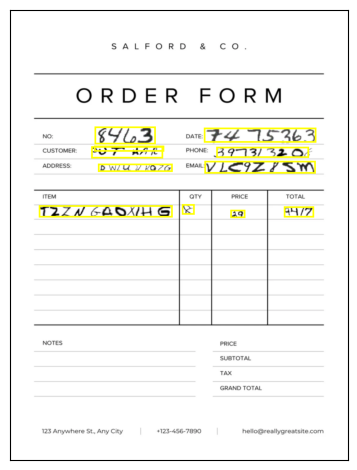

In [32]:
plot([(image, prediction)])

### Evaluate Test images

In [33]:
img = Image.open(documents_dir / "test" / "sample_139.png")

In [34]:
image, prediction = process_document(model, img, transform, confidence_threshold=0.15)

In [35]:
prediction

{'boxes': tensor([[362.1898, 269.7720, 529.4404, 290.0881],
         [209.4743, 210.7167, 280.3650, 230.9814],
         [ 45.6174, 348.6387, 291.9974, 367.7871],
         [464.5494, 347.8715, 503.5728, 365.7602],
         [123.7666, 240.7220, 296.5563, 262.1523],
         [368.6368, 347.8312, 401.1440, 374.0100],
         [405.3450, 215.2495, 513.1550, 233.4021],
         [ 48.6160, 347.2253, 294.4474, 358.0057],
         [351.6517, 241.5632, 555.3654, 262.6788],
         [106.7477, 271.9707, 203.1971, 282.3798],
         [326.7648, 343.8895, 345.0739, 359.8278]]),
 'labels': tensor([ 9,  5,  1,  4,  6,  8,  2,  1,  7, 10,  3]),
 'scores': tensor([0.9796, 0.9794, 0.9757, 0.9652, 0.9614, 0.9350, 0.9113, 0.8897, 0.8630,
         0.7194, 0.6823])}

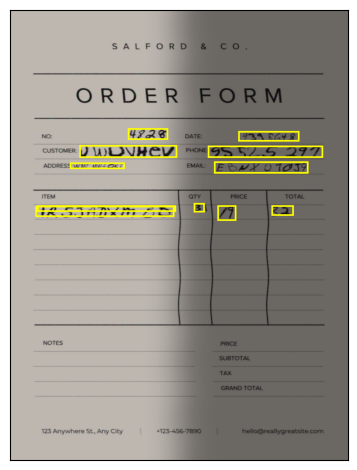

In [36]:
plot([(image, prediction)])

In [37]:
train_dataset.classes

{'Item 1': 1,
 'Date': 2,
 'Quantity 1': 3,
 'Total 1': 4,
 'Number': 5,
 'Customer': 6,
 'Phone': 7,
 'Price 1': 8,
 'Email': 9,
 'Address': 10}

## Real Image

In [38]:
import cv2

In [39]:
def align_to_template(image, template):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    orb = cv2.SIFT_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(template_gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_SL2)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches = sorted(matches, key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    num_good_matches = int(len(matches) * 0.15)
    matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = template_gray.shape
    registered_image = cv2.warpPerspective(image, h, (width, height))

    return registered_image

In [40]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_1.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [41]:
registered_image = align_to_template(image, template)
registered_image = Image.fromarray(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))

In [42]:
image, prediction = process_document(model, registered_image, transform, confidence_threshold=0.5)

In [43]:
prediction

{'boxes': tensor([[344.5767, 272.6773, 547.5582, 291.0132],
         [348.9476, 218.8887, 489.2362, 238.1691],
         [ 55.4602, 353.5995, 169.9774, 369.4115],
         [ 95.3464, 215.7880, 139.3599, 231.8098],
         [110.1639, 274.5089, 232.2713, 291.4942],
         [475.4423, 352.7885, 519.9735, 366.2833],
         [130.0345, 244.8464, 213.3548, 259.8896],
         [375.1742, 350.5284, 412.5424, 363.5546]]),
 'labels': tensor([ 9,  2,  1,  5, 10,  4,  6,  8]),
 'scores': tensor([0.9793, 0.9141, 0.9073, 0.8782, 0.8501, 0.8147, 0.7350, 0.6277])}

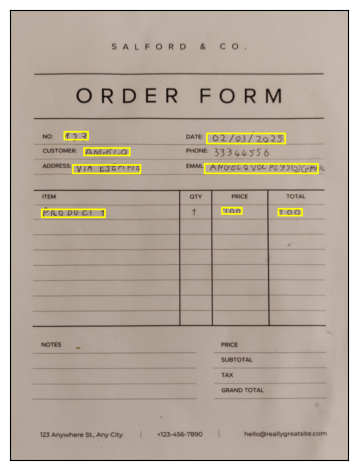

In [44]:
plot([(image, prediction)])